# **Sentiment Analysis using LSTM**

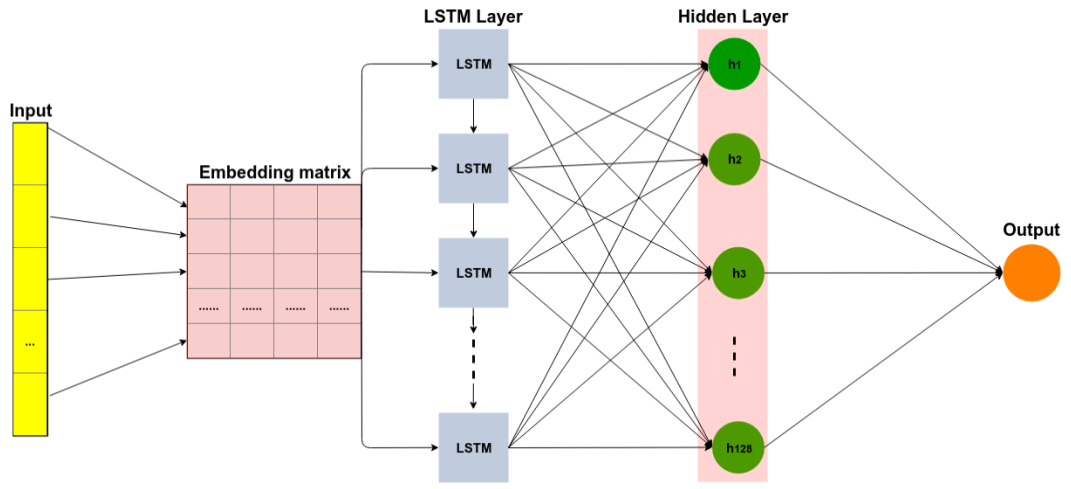

In [2]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# read a file
gdrive_path = '/content/drive/MyDrive/mydata/'

In [4]:
#read the reviews
import pandas as pd
#df = pd.read_excel(f"{gdrive_path}IMDB_Dataset_label.csv")

data = pd.read_csv(f"{gdrive_path}IMDB_Dataset_label.csv", error_bad_lines=False)
data.sample(n=10)

<ipython-input-4-c76a2d932320>:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f"{gdrive_path}IMDB_Dataset_label.csv", error_bad_lines=False)


,Unnamed: 0,review,sentiment,label
14025,14025,After the lead actress of the opera is killed ...,positive,1
14477,14477,"This is an extraordinary film, that tricks you...",positive,1
905,905,Well where do I begin my story?? I went to thi...,negative,0
24336,24336,"Steve Carell plays Dan Burns, newspaper agony ...",positive,1
30220,30220,"Oh, brother. The only reason this very irritat...",negative,0
24516,24516,"2003 was seen as the year of the Matrix, with ...",positive,1
15917,15917,"I rarely give ratings less than 5, but in this...",negative,0
41227,41227,John Carpenter's Halloween<br /><br />Is it th...,positive,1
16688,16688,i watched the longer version and could not tak...,positive,1
254,254,"Well, here's another terrific example of awkwa...",positive,1


In [5]:
data.groupby('sentiment').describe()

Unnamed: 0                                                    \
               count         mean           std  min      25%      50%   
sentiment                                                                
negative     25000.0  24964.07768  14461.920812  3.0  12403.5  24940.0   
positive     25000.0  25034.92232  14406.028970  0.0  12577.0  25039.0   

                                label                                     
                75%      max    count mean  std  min  25%  50%  75%  max  
sentiment                                                                 
negative   37482.50  49999.0  25000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
positive   37524.25  49995.0  25000.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [6]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

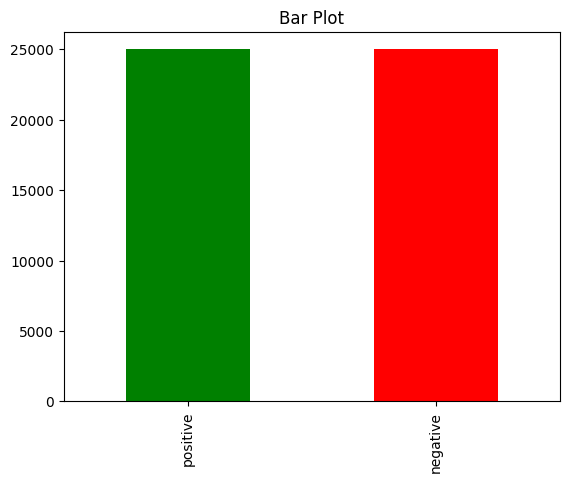

In [7]:
import matplotlib.pyplot as plt

count_Class=pd.value_counts(data["sentiment"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Bar Plot')
plt.show()

In [8]:
neg_data  = data[data['label'] == 0].copy()
pos_data = data[data['label'] == 1].copy()

In [9]:
import wordcloud
from wordcloud import WordCloud
def show_wordcloud(df, title):
    text = ' '.join(df['review'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

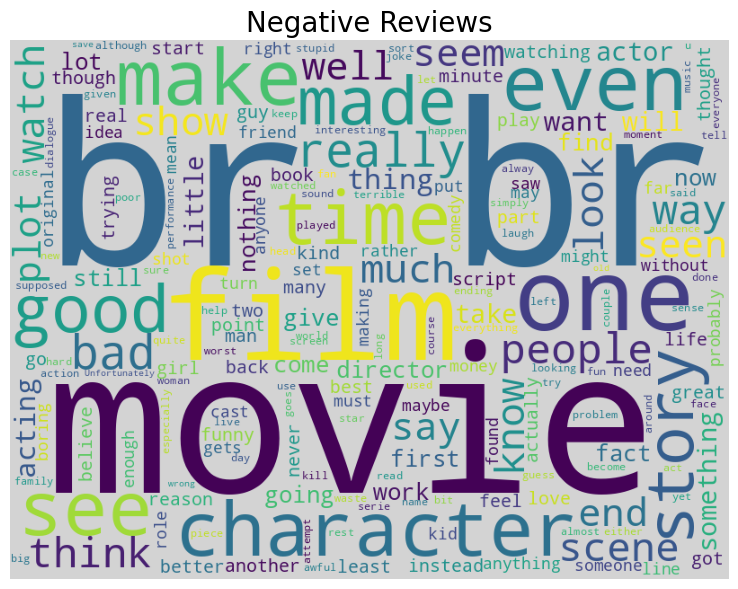

In [10]:
show_wordcloud(neg_data, "Negative Reviews")

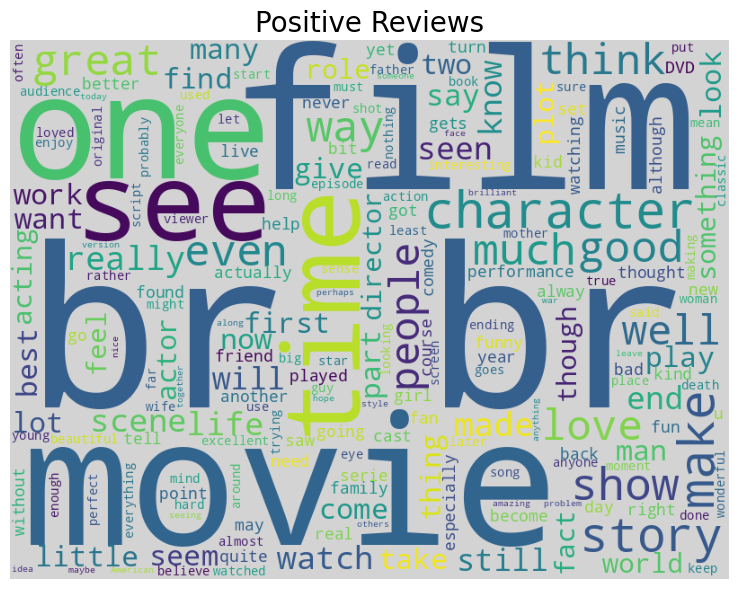

In [11]:
show_wordcloud(pos_data, "Positive Reviews")

In [12]:
# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
from collections import Counter
import time



In [13]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "positive"
NEGATIVE = "negative"
NEUTRAL = "neutral"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "Sentiment_lstm_w2v.sav"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "lstm_w2v_tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


Text(0.5, 1.0, 'Dataset labels distribuition')

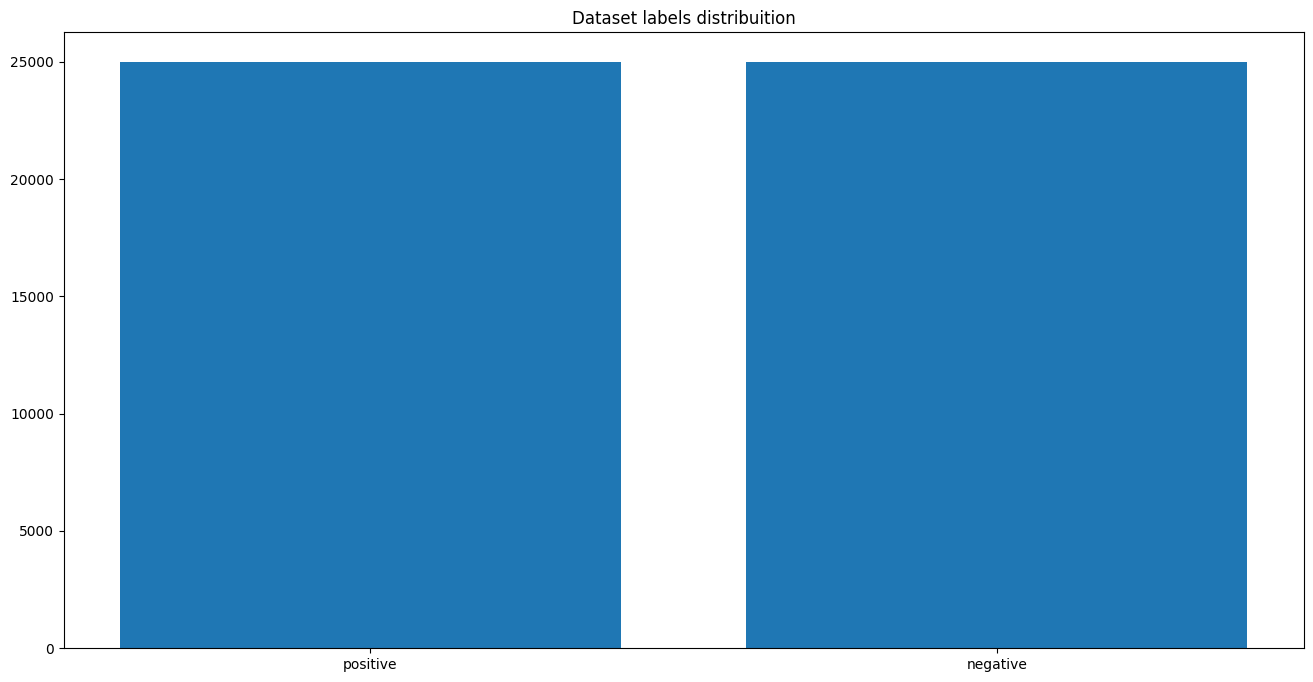

In [14]:
target_cnt = Counter(data.sentiment)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [17]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [18]:
%%time
data.review = data.review.apply(lambda x: preprocess(x))

CPU times: user 22.9 s, sys: 122 ms, total: 23.1 s
Wall time: 23.3 s


In [19]:
data.sample(n=10)

,Unnamed: 0,review,sentiment,label
11675,11675,essential part british pop culture monty pytho...,positive,1
39108,39108,disjointed seemed jump place place thief obvio...,negative,0
22522,22522,ok admit started pleasing good dropped downhil...,negative,0
46744,46744,video 100 retarded besides brain cell killing ...,negative,0
30951,30951,episode boring even realm horror far season ma...,negative,0
12857,12857,bear mind film let alone documentary asserts k...,positive,1
30852,30852,maybe former hippie fully appreciate aside dat...,negative,0
48797,48797,warning herzog filmaker tends bit overly drama...,positive,1
29677,29677,film sat tivo weeks watched dreaded self indul...,positive,1
30386,30386,great adaptation great miniseries right plot c...,positive,1


In [20]:
# split data into train and test set
from sklearn.model_selection import train_test_split

X = data['review'].values
y = data['sentiment'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [21]:
%%time
documents = [_text.split() for _text in data.review]

CPU times: user 678 ms, sys: 247 ms, total: 926 ms
Wall time: 963 ms


In [22]:
print(len(documents))

50000


In [23]:
# Train Word2Vec model
w2vmodel = gensim.models.Word2Vec(documents, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)


In [24]:
words = w2vmodel.wv.index_to_key
vocab_size_wv = len(words)
print("Vocab size:", vocab_size_wv)

Vocab size: 28058


In [25]:
w2vmodel.wv.most_similar("movie")

[('film', 0.6630565524101257),
 ('movies', 0.6224458813667297),
 ('flick', 0.6014751195907593),
 ('think', 0.48842883110046387),
 ('guess', 0.48436617851257324),
 ('sure', 0.47803959250450134),
 ('figured', 0.477205365896225),
 ('honestly', 0.4691869616508484),
 ('thats', 0.46580827236175537),
 ('anyways', 0.4636055827140808)]

In [26]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.review)



CPU times: user 5.43 s, sys: 47.2 ms, total: 5.47 s
Wall time: 5.47 s


In [27]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 100947


In [28]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

CPU times: user 5.25 s, sys: 78.8 ms, total: 5.33 s
Wall time: 5.4 s


In [29]:
labels = data.sentiment.unique().tolist()
labels.append("neutral")
labels

['positive', 'negative', 'neutral']

In [30]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(data.sentiment.tolist())

y_train = encoder.transform(Y_train.tolist()) 
y_test = encoder.transform(Y_test.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (40000, 1)
y_test (10000, 1)


In [31]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (40000, 300)
y_train (40000, 1)

x_test (10000, 300)
y_test (10000, 1)


In [32]:
y_train[:10]

array([[0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]])

**Embedding layer**

In [33]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2vmodel.wv:
    embedding_matrix[i] = w2vmodel.wv[word]
print(embedding_matrix.shape)

(100947, 300)


In [34]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

**Build Model**

In [35]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          30284100  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 30,444,601
Trainable params: 160,501
Non-trainable params: 30,284,100
_________________________________________________________________


**Compile model**

In [36]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

**Callbacks**

In [37]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)] #change 'val_acc' to 'val_accuracy'

**Train**

In [38]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

import pickle

model.save(KERAS_MODEL)
w2vmodel.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)


acc = history.history['acc']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()



Epoch 1/32
36/36 [==============================] - ETA: 0s - loss: 0.5151 - accuracy: 0.7423

36/36 [==============================] - 60s 1s/step - loss: 0.5151 - accuracy: 0.7423 - val_loss: 0.5229 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 2/32
36/36 [==============================] - ETA: 0s - loss: 0.3804 - accuracy: 0.8361

36/36 [==============================] - 50s 1s/step - loss: 0.3804 - accuracy: 0.8361 - val_loss: 0.3644 - val_accuracy: 0.8570 - lr: 0.0010
Epoch 3/32
36/36 [==============================] - ETA: 0s - loss: 0.3601 - accuracy: 0.8468

36/36 [==============================] - 49s 1s/step - loss: 0.3601 - accuracy: 0.8468 - val_loss: 0.4220 - val_accuracy: 0.8505 - lr: 0.0010
Epoch 4/32
36/36 [==============================] - ETA: 0s - loss: 0.3353 - accuracy: 0.8571

36/36 [==============================] - 51s 1s/step - loss: 0.3353 - accuracy: 0.8571 - val_loss: 0.3066 - val_accuracy: 0.8752 - lr: 0.0010
Epoch 5/32
36/36 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8677

36/36 [==============================] - 49s 1s/step - loss: 0.3121 - accuracy: 0.8677 - val_loss: 0.2797 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 6/32
36/36 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.8773

36/36 [==============================] - 51s 1s/step - loss: 0.2922 - accuracy: 0.8773 - val_loss: 0.2990 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 7/32
36/36 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.8805

36/36 [==============================] - 50s 1s/step - loss: 0.2866 - accuracy: 0.8805 - val_loss: 0.2799 - val_accuracy: 0.8873 - lr: 0.0010
Epoch 8/32
36/36 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.8837

36/36 [==============================] - 51s 1s/step - loss: 0.2792 - accuracy: 0.8837 - val_loss: 0.2943 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 9/32
36/36 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.8859

36/36 [==============================] - 49s 1s/step - loss: 0.2734 - accuracy: 0.8859 - val_loss: 0.2909 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 10/32
36/36 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.8889

36/36 [==============================] - 52s 1s/step - loss: 0.2686 - accuracy: 0.8889 - val_loss: 0.2586 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 11/32
36/36 [==============================] - ETA: 0s - loss: 0.2655 - accuracy: 0.8916

36/36 [==============================] - 51s 1s/step - loss: 0.2655 - accuracy: 0.8916 - val_loss: 0.2611 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 12/32
36/36 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.8947

36/36 [==============================] - 49s 1s/step - loss: 0.2567 - accuracy: 0.8947 - val_loss: 0.2715 - val_accuracy: 0.8825 - lr: 0.0010
Epoch 13/32
36/36 [==============================] - ETA: 0s - loss: 0.2542 - accuracy: 0.8954

36/36 [==============================] - 51s 1s/step - loss: 0.2542 - accuracy: 0.8954 - val_loss: 0.2649 - val_accuracy: 0.8928 - lr: 0.0010
Epoch 14/32
36/36 [==============================] - ETA: 0s - loss: 0.2518 - accuracy: 0.8964

36/36 [==============================] - 48s 1s/step - loss: 0.2518 - accuracy: 0.8964 - val_loss: 0.2484 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 15/32
36/36 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.8985

36/36 [==============================] - 51s 1s/step - loss: 0.2474 - accuracy: 0.8985 - val_loss: 0.2502 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 16/32
36/36 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.8979

36/36 [==============================] - 48s 1s/step - loss: 0.2475 - accuracy: 0.8979 - val_loss: 0.2401 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 17/32
36/36 [==============================] - ETA: 0s - loss: 0.2394 - accuracy: 0.9018

36/36 [==============================] - 51s 1s/step - loss: 0.2394 - accuracy: 0.9018 - val_loss: 0.2443 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 18/32
36/36 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9018

36/36 [==============================] - 49s 1s/step - loss: 0.2352 - accuracy: 0.9018 - val_loss: 0.2385 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 19/32
36/36 [==============================] - ETA: 0s - loss: 0.2365 - accuracy: 0.9027

36/36 [==============================] - 51s 1s/step - loss: 0.2365 - accuracy: 0.9027 - val_loss: 0.2477 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 20/32
36/36 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.9063

36/36 [==============================] - 52s 1s/step - loss: 0.2287 - accuracy: 0.9063 - val_loss: 0.2426 - val_accuracy: 0.9007 - lr: 0.0010
Epoch 21/32
36/36 [==============================] - ETA: 0s - loss: 0.2290 - accuracy: 0.9083

36/36 [==============================] - 49s 1s/step - loss: 0.2290 - accuracy: 0.9083 - val_loss: 0.2407 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 22/32
36/36 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9097

36/36 [==============================] - 51s 1s/step - loss: 0.2241 - accuracy: 0.9097 - val_loss: 0.2372 - val_accuracy: 0.9020 - lr: 0.0010
Epoch 23/32
36/36 [==============================] - ETA: 0s - loss: 0.2240 - accuracy: 0.9084

36/36 [==============================] - 49s 1s/step - loss: 0.2240 - accuracy: 0.9084 - val_loss: 0.2442 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 24/32
36/36 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.9112

36/36 [==============================] - 52s 1s/step - loss: 0.2203 - accuracy: 0.9112 - val_loss: 0.2438 - val_accuracy: 0.9028 - lr: 0.0010
Epoch 25/32
36/36 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.9108

36/36 [==============================] - 49s 1s/step - loss: 0.2175 - accuracy: 0.9108 - val_loss: 0.2654 - val_accuracy: 0.8938 - lr: 0.0010
Epoch 26/32
36/36 [==============================] - ETA: 0s - loss: 0.2177 - accuracy: 0.9122

36/36 [==============================] - 51s 1s/step - loss: 0.2177 - accuracy: 0.9122 - val_loss: 0.2544 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 27/32
36/36 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9148

36/36 [==============================] - 50s 1s/step - loss: 0.2113 - accuracy: 0.9148 - val_loss: 0.2369 - val_accuracy: 0.9020 - lr: 0.0010
Epoch 28/32
36/36 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9141

36/36 [==============================] - 50s 1s/step - loss: 0.2129 - accuracy: 0.9141 - val_loss: 0.2267 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 29/32
36/36 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.9156

36/36 [==============================] - 51s 1s/step - loss: 0.2108 - accuracy: 0.9156 - val_loss: 0.2341 - val_accuracy: 0.9047 - lr: 0.0010
Epoch 30/32
36/36 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9154

36/36 [==============================] - 49s 1s/step - loss: 0.2056 - accuracy: 0.9154 - val_loss: 0.2580 - val_accuracy: 0.9010 - lr: 0.0010
Epoch 31/32
36/36 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9179

36/36 [==============================] - 51s 1s/step - loss: 0.2042 - accuracy: 0.9179 - val_loss: 0.2524 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 32/32
36/36 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9161

36/36 [==============================] - 49s 1s/step - loss: 0.2075 - accuracy: 0.9161 - val_loss: 0.2368 - val_accuracy: 0.9043 - lr: 0.0010


KeyError: ignored

**Evaluate**

In [39]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 1s 108ms/step - loss: 0.2419 - accuracy: 0.9057

ACCURACY: 0.9057000279426575
LOSS: 0.24188390374183655
CPU times: user 1.05 s, sys: 129 ms, total: 1.18 s
Wall time: 1.34 s


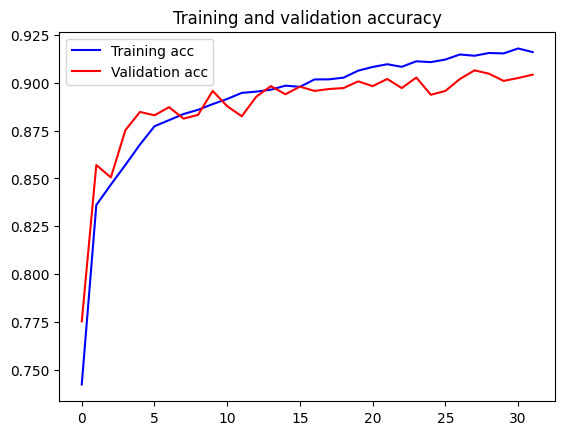

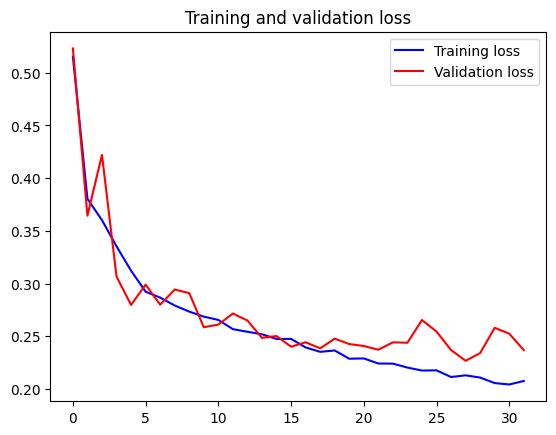

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**Predict**

In [42]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [43]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [44]:
predict("I think this is a very great movie.")

1/1 [==============================] - 2s 2s/step


{'label': 'positive',
 'score': 0.967143714427948,
 'elapsed_time': 2.1900055408477783}

**Confusion Matrix**

In [45]:
%%time
y_pred_1d = []
y_test_1d = list(Y_test)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 1s 186ms/step
CPU times: user 844 ms, sys: 342 ms, total: 1.19 s
Wall time: 1.58 s


In [46]:
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

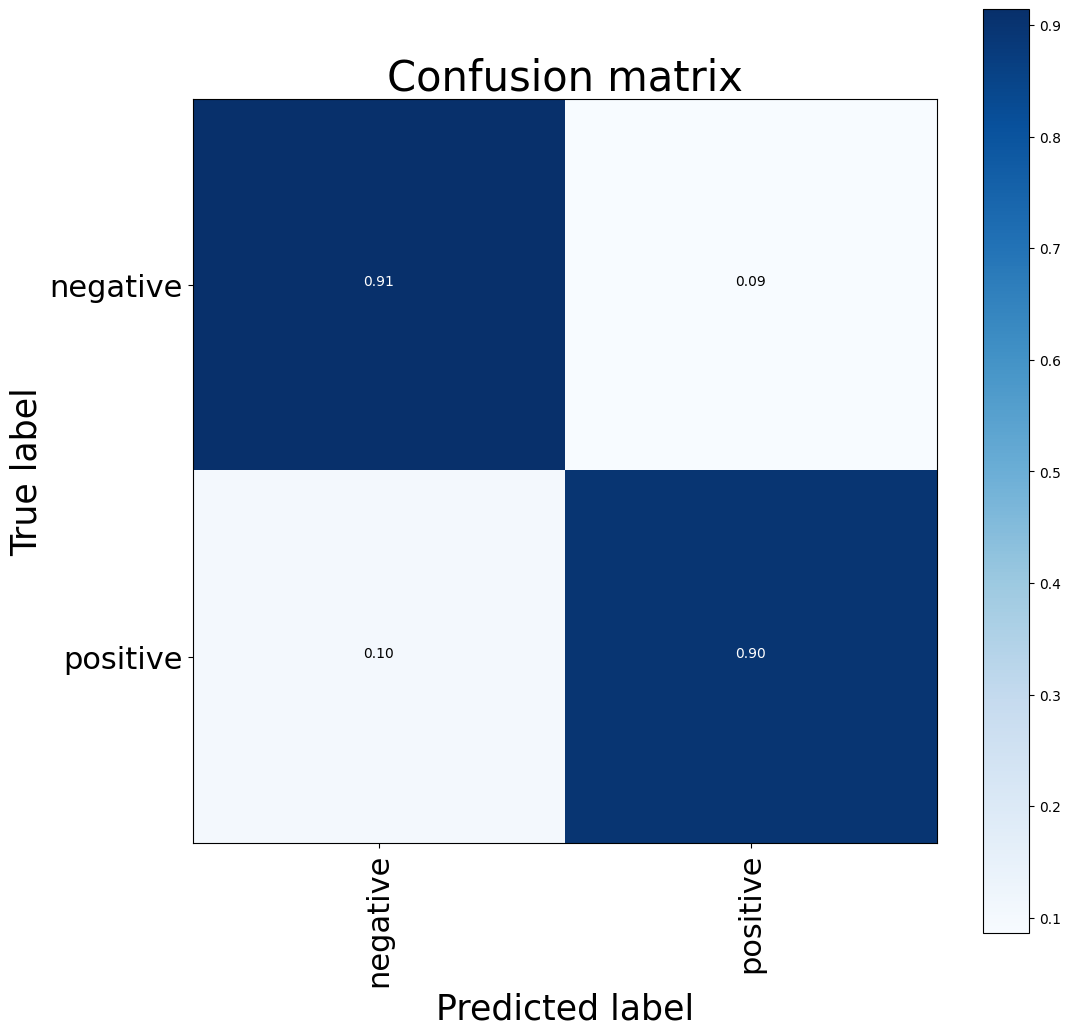

CPU times: user 432 ms, sys: 248 ms, total: 679 ms
Wall time: 413 ms


In [49]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(Y_train), title="Confusion matrix")
plt.show()

**Classification Report**

In [50]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    negative       0.90      0.91      0.91      4961
    positive       0.91      0.90      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



**Accuracy Score**

In [51]:
accuracy_score(y_test_1d, y_pred_1d)

0.9057

**Save model**

In [53]:
import pickle

model.save(f"{gdrive_path}{KERAS_MODEL}")
w2vmodel.save(f"{gdrive_path}{WORD2VEC_MODEL}")
pickle.dump(tokenizer, open(f"{gdrive_path}{TOKENIZER_MODEL}", "wb"), protocol=0)
pickle.dump(encoder, open(f"{gdrive_path}{ENCODER_MODEL}", "wb"), protocol=0)